# Custom models



In this document we develop custom sklearn estimators. The main outcome is a hybrid machine learning model which evaluates a linear regression if a certain condition is met, and evaluates another linear regression, or gives a trivial output, if the condition is not met.  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, cross_validate

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression

from matplotlib_venn import venn2
from tqdm import tqdm

from imblearn.over_sampling import SMOTENC




In [2]:
import pickle

In [3]:
import src.features as features
import src.model_selection as model_selection 
import src.functions as functions
import src.datasets as datasets 

## Developing a custom sklearn estimator

We follow the guides at the following links 
- https://sklearn-template.readthedocs.io/en/latest/user_guide.html
- https://scikit-learn.org/dev/developers/develop.html


In [4]:
from sklearn.base import ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.utils.validation import check_is_fitted

### The dodel "OffLogistic" definition

In [28]:


class OffLogistic(ClassifierMixin):
    def __init__(self, random_state = 42, features = []):
        # parameters
        self.random_state = random_state

        # internal variable, exposed to user
        self.model_ = LogisticRegression(random_state=random_state)
        self.features_ = features

    def fit(self, X, y):

        # expect feature names for X
        # expect variables offtrt and time
        

        mask_on = X['offtrt'] < 0
        if "time" in X.columns:
            mask_time = X['time'] <= 707
        elif "time_censored" in X.columns:
            mask_time = X['time_censored'] >= -0.33836866


        if len(self.features_) > 0:
            X_fit = X.copy()[self.features_]
        else:
            X_fit = X.copy()

        #X_on_time = X[mask_on & mask_time]
        X_other = X_fit[~(mask_on & mask_time)]
        y_other = y[~(mask_on & mask_time)]

        self.model_.fit(X_other,y_other)

        return self
    
    def predict(self,X) :

        
        if len(self.features_) > 0:
            X_fit = X.copy()[self.features_]
        else:
            X_fit = X.copy()
        

        mask_on = X_fit['offtrt'] < 0
        if "time" in X.columns:
            mask_time = X_fit['time'] <= 707
        elif "time_censored" in X.columns:
            mask_time = X_fit['time_censored'] >= -0.33836866

        X_on_time = X_fit[mask_on & mask_time]
        X_other = X_fit[~(mask_on & mask_time)]

        y_pred = pd.Series(index=X.index)

        y_pred.loc[mask_on & mask_time] = 1
        y_pred.loc[~(mask_on & mask_time)] = self.model_.predict(X_other)
        
        return y_pred 
    

    def predict_proba(self,X) :

        if len(self.features_) > 0:
            X_fit = X.copy()[self.features_]
        



        mask_on = X_fit['offtrt'] < 0
        if "time" in X_fit.columns:
            mask_time = X_fit['time'] <= 707
        elif "time_censored" in X.columns:
            mask_time = X_fit['time_censored'] >= -0.33836866

        X_on_time = X_fit[mask_on & mask_time]
        X_other = X_fit[~(mask_on & mask_time)]

        y_proba = pd.Series(index=X.index)

        y_proba.loc[mask_on & mask_time] = (0,1)
        y_proba.loc[~(mask_on & mask_time)] = self.model_.predict_proba(X_other)
        
        return y_proba


    def get_params(self, deep=True):
        """
        Return the parameters of the classifier as a dictionary.
        The get_params function takes no arguments and returns a dict of the __init__ parameters of the estimator, together with their values.
        """
        return {"random_state": self.random_state, "features": self.features_}

    def set_params(self, **params):
        """
        Set the parameters of the classifier.
        """
        for key, value in params.items():
            setattr(self, key, value)
        return self




    

### The model "OffLogistic2"

In [14]:

class OffLogistic2(ClassifierMixin):
    def __init__(self, 
                random_state = 42, 
                features_on = ['z30', 'cd420', 'time730'], 
                features_off = ['age', 'drugs', 'hemo', 'cd820', 'preanti', 'race', 'cd420', 'time730', 'z30', 'time_censored']):
        # parameters
        self.random_state = random_state
        self.features_off = features_off
        self.features_on = features_on

        # internal variables, exposed to user
        self.model_on_ = LogisticRegression(random_state=random_state)
        self.model_off_ = LogisticRegression(random_state=random_state)
    
    def mask_on_time1(self,X,y):      
        mask_time1 = X['time_censored']>=-0.33836866
        mask_on = X['offtrt']<0

        X_on = X[ mask_on & mask_time1]
        y_on = y[ mask_on & mask_time1]

        X_on_copy = X_on.copy() #.drop(columns = ['offtrt'])

        return X_on_copy, y_on.copy(), mask_on & mask_time1

    def mask_on_time2(self,X,y):      
        mask_time2 = X['time_censored']<-0.33836866
        mask_on = X['offtrt']<0

        X_on = X[ mask_on & mask_time2]
        y_on = y[ mask_on & mask_time2]
        
        X_on = X_on[self.features_on]


        X_on_copy = X_on.copy() #.drop(columns = ['offtrt'])

        return X_on_copy, y_on.copy(), mask_on & mask_time2

    def mask_off(self,X,y):
        mask_off = X['offtrt']>0

        X_off = X[ mask_off]
        y_off = y[ mask_off]

        X_off = X_off[self.features_off]

        X_off_copy = X_off.copy() #.drop(columns = ['offtrt'])


        return X_off_copy, y_off, mask_off


    def fit(self, X, y):

        # expect feature names for X
        # expect variables offtrt and time_censored
        
        X_on_time1, y_on_time1, mask_on_time1 = self.mask_on_time1(X,y)
        X_on_time2, y_on_time2, mask_on_time2 = self.mask_on_time2(X,y)
        X_off, y_off, mask_off = self.mask_off(X,y)
        
        self.model_on_.fit(X_on_time2,y_on_time2)
        self.model_off_.fit(X_off,y_off)

        return self
    
    def predict(self,X) :

        
        X_on_time1, y_on_time1, mask_on_time1 = self.mask_on_time1(X,X)
        X_on_time2, y_on_time2, mask_on_time2 = self.mask_on_time2(X,X)
        X_off, y_off, mask_off = self.mask_off(X,X)
        
        y_pred = pd.Series(index=X.index)

        y_pred.loc[mask_on_time1] = 1
        y_pred.loc[mask_on_time2] = self.model_on_.predict(X_on_time2)
        y_pred.loc[mask_off] = self.model_off_.predict(X_off)
        
        return y_pred 
    

    def predict_proba(self,X) :

        
        X_on_time1, y_on_time1, mask_on_time1 = self.mask_on_time1(X,X)
        X_on_time2, y_on_time2, mask_on_time2 = self.mask_on_time2(X,X)
        X_off, y_off, mask_off = self.mask_off(X,X)
        

        y_proba = pd.Series(index=X.index)

        y_proba.loc[mask_on_time1] = [[0, 1]] * mask_on_time1.sum()
        y_proba.loc[mask_on_time2] = self.model_on_.predict_proba(X_on_time2)
        y_proba.loc[mask_off] = self.model_off_.predict_proba(X_off)
        
        return y_proba


    def get_params(self, deep=True):
        """
        Return the parameters of the classifier as a dictionary.
        """
        return {"random_state": self.random_state, "features_on": self.features_on, "features_off": self.features_off}

    def set_params(self, **params):
        """
        Set the parameters of the classifier.
        """
        for key, value in params.items():
            setattr(self, key, value)
        return self




    

## Load data

In [7]:
data = datasets.data_original()

In [8]:
data = features.engineer(data)

### Train test split (unprocessed)

In [9]:
X_, y_ = data.drop('infected', axis=1), data['infected']
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_, test_size = 0.2, random_state=42, stratify = y_)


### Oversampling train data 

In [10]:
# identify categorical features 
# The dataset does not have categorical features with more than 4 categories
cat_features = [c for c in X_train_.columns if X_train_[c].nunique() < 5]

In [11]:
smote_nc = SMOTENC(categorical_features=cat_features, sampling_strategy=1.0, random_state=42)
X_oversampled, y_oversampled = smote_nc.fit_resample(X_train_, y_train_) 

### Scaling the data 

In [12]:
scaler = StandardScaler()

scaler.fit(X_train_)

X_train_scaled_oversampled = scaler.transform(X_oversampled)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_), columns = X_train_.columns)
X_train_scaled = pd.DataFrame(scaler.transform(X_train_), columns = X_train_.columns)

### Data ready for Machine Learning

In [13]:
X_train =pd.DataFrame(X_train_scaled_oversampled,columns=X_.columns)
X_test =pd.DataFrame(X_test_scaled,columns=X_.columns)
y_train =y_oversampled 
y_test = y_test_ 

## Train test evaluation

### Load and train the models

In [29]:
model1 = OffLogistic()
model2 = OffLogistic2()

In [30]:
model1.fit(X_train,y_train)
model2.fit(X_train,y_train)

### Test accuracy and recall

In [31]:
y_pred1 = model1.predict(X_test)
y_pred2 = model2.predict(X_test)

In [33]:
print("OffLogistic test accuracy", accuracy_score(y_pred1,y_test))
print("OffLogistic2 test accuracy", accuracy_score(y_pred2,y_test))

OffLogistic test accuracy 0.8995327102803738
OffLogistic2 test accuracy 0.9112149532710281


In [34]:
print("OffLogistic test recall", recall_score(y_pred1,y_test))
print("OffLogistic2 test recall", recall_score(y_pred2,y_test))

OffLogistic test recall 0.7850467289719626
OffLogistic2 test recall 0.8055555555555556


## CV scoring ad hoc

In [33]:
from sklearn.base import clone


In [52]:
def cv_accuracy_recall(Xtrain, ytrain, model, title= "modelname", verbose = False, n_splits = 5):
    # Create the K-Fold cross-validator
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    X_train_reindexed = Xtrain.copy()
    X_train_reindexed.reset_index(inplace=True, drop = True)
    y_train_reindexed = ytrain.copy()
    y_train_reindexed.reset_index(drop=True, inplace=True)
    
    recall = []
    accuracy = []
    i = 0

    # source https://kiwidamien.github.io/how-to-do-cross-validation-when-upsampling-data.html
    for train_fold_index, val_fold_index in cv.split(X_train_reindexed, y_train_reindexed):
        


        # Get the training data
        X_train_fold, y_train_fold = X_train_reindexed.iloc[train_fold_index], y_train_reindexed[train_fold_index]
        # Get the validation data
        X_val_fold, y_val_fold = X_train_reindexed.iloc[val_fold_index], y_train_reindexed[val_fold_index]

        if verbose:
            print("fold number :", i)

        # create a untrained copy of the model with same hyperparameters
        model_cv = clone(model)
        
        model_cv.fit(X_train_fold, y_train_fold)
        y_pred  = model_cv.predict(X_val_fold)

        accuracy.append(accuracy_score(y_pred,y_val_fold))
        recall.append(recall_score(y_pred,y_val_fold))

        i+=1

    cv_scores = {
        "model" : title,
        "accuracy" : sum(accuracy)/n_splits,
        "recall" : sum(recall)/n_splits
    }
    return cv_scores

In [53]:
cv_accuracy_recall(X_train_scaled,y_train_,model, "OffLogistic10")

{'model': 'OffLogistic10',
 'accuracy': 0.8866110855369718,
 'recall': np.float64(0.7926048611462132)}

## CV scoring imnblearn

In [23]:
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline, make_pipeline

cat_features = [c for c in X_train_ if X_train_[c].nunique() < 5]
smote_nc =  SMOTENC(categorical_features=cat_features, sampling_strategy=1.0, random_state=42)

In [25]:
from src.model_selection import cv_accuracy_recall

In [31]:
model = OffLogistic(features=rfe_features)
imba_pipeline = make_pipeline(smote_nc, model)
cv_accuracy_recall(X_,y_, imba_pipeline, "OffLogistic10")

{'accuracy': np.float64(nan),
 'recall': np.float64(nan),
 'model': 'OffLogistic10'}

In [29]:
X_train.columns

Index(['age', 'wtkg', 'hemo', 'homo', 'drugs', 'karnof', 'oprior', 'z30',
       'preanti', 'race', 'gender', 'str2', 'strat', 'symptom', 'offtrt',
       'cd40', 'cd420', 'cd80', 'cd820', 'time730', 'time_censored', 'trt0',
       'trt1', 'trt2'],
      dtype='object')

## 042-Sprint2 feature selection for oversampled data

In [243]:

def cv_mean_scores(Xtrain, ytrain, model = OffLogistic(), n_splits  = 5):
    # Create the K-Fold cross-validator
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
     
    # Choose the scores to be computed
    selectivity_score = make_scorer(recall_score, pos_label = 0)

    f3_score = make_scorer(fbeta_score,beta = 3)

    my_scores= {
        "accuracy": "accuracy",
        "f3": f3_score,
        "recall": "recall",
        "selectivity": selectivity_score, 
        "precision": "precision",
        "f1": "f1"
    }

    # Perform cross-validation measuring the scores
    cv_results = cross_validate(
        model, Xtrain, ytrain, cv=cv, n_jobs=-1, scoring= my_scores
    )


    # Calculate the mean of each score
    mean_scores =  {score : cv_results["test_"+score].mean() for score in my_scores}
    return mean_scores



### 042-043 Cross-validation for RFE 

In [244]:
def rfe_kfold_cv(X, y, max_k=None, cv=5, verbose = False):
    if max_k is None:
        max_k = X.shape[1]
    
    results_rfe_kfold_cv = []
    for k in range(1, max_k + 1):
        
        
        rfe = RFE(estimator=LogisticRegression(), n_features_to_select=k)
        rfe.fit(X, y)
        selected_features = list(set(X.columns[rfe.support_]).union(set(['offtrt', 'time_censored'])))
        
        model = OffLogistic(features=selected_features)
        skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
        
        cv_scores = cv_mean_scores(X[selected_features], y, model)
        
        cv_scores["k"] = k
        cv_scores["features"] = list(selected_features)

        results_rfe_kfold_cv.append( cv_scores)

        if verbose:
            print(k)
            print(pd.DataFrame(cv_scores))
    
    return pd.DataFrame(results_rfe_kfold_cv).set_index('k')

In [245]:
results_rfe_kfold_cv = rfe_kfold_cv(X_train,y_train,cv=5)


In [246]:
print(results_rfe_kfold_cv)


    accuracy  f3  recall  selectivity  precision  f1  \
k                                                      
1        NaN NaN     NaN          NaN        NaN NaN   
2        NaN NaN     NaN          NaN        NaN NaN   
3        NaN NaN     NaN          NaN        NaN NaN   
4        NaN NaN     NaN          NaN        NaN NaN   
5        NaN NaN     NaN          NaN        NaN NaN   
6        NaN NaN     NaN          NaN        NaN NaN   
7        NaN NaN     NaN          NaN        NaN NaN   
8        NaN NaN     NaN          NaN        NaN NaN   
9        NaN NaN     NaN          NaN        NaN NaN   
10       NaN NaN     NaN          NaN        NaN NaN   
11       NaN NaN     NaN          NaN        NaN NaN   
12       NaN NaN     NaN          NaN        NaN NaN   
13       NaN NaN     NaN          NaN        NaN NaN   
14       NaN NaN     NaN          NaN        NaN NaN   
15       NaN NaN     NaN          NaN        NaN NaN   
16       NaN NaN     NaN          NaN        NaN

In [247]:
old_rfe_features = set()
for k in range(len(results_rfe_kfold_cv['features'])):
    new_rfe_features = set(list(results_rfe_kfold_cv['features'])[k])
    new_feature = new_rfe_features - old_rfe_features
    old_rfe_features = new_rfe_features
    print(k, new_feature)


0 {'time730', 'offtrt', 'time_censored'}
1 set()
2 {'cd420'}
3 {'race'}
4 {'hemo'}
5 {'drugs'}
6 {'z30'}
7 {'gender'}
8 set()
9 {'trt1'}
10 {'trt2'}
11 {'str2'}
12 {'preanti'}
13 {'cd80'}
14 {'age'}
15 {'karnof'}
16 {'cd820'}
17 {'cd40'}
18 {'wtkg'}
19 {'trt0'}
20 {'oprior'}
21 {'symptom'}
22 {'homo'}
23 {'strat'}


In [294]:
for rfe_features in results_rfe_kfold_cv['features']:
    #rfe_features = ['hemo', 'drugs', 'z30', 'race', 'gender', 'offtrt', 'cd420', 'time730', 'time_censored', 'cd80']

    model = OffLogistic(features=rfe_features)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_pred,y_test)
    rec = recall_score(y_pred,y_test)

    model = LogisticRegression(random_state = 42)
    X_rfe = X_train[rfe_features]
    model.fit(X_rfe,y_train)
    y_pred = model.predict(X_test[rfe_features])
    acc2 = accuracy_score(y_pred,y_test)
    rec2 = recall_score(y_pred,y_test)

    print(len(rfe_features), acc, rec , "compare", acc2, rec2)

3 0.8200934579439252 0.5944055944055944 compare 0.8200934579439252 0.5944055944055944
3 0.8200934579439252 0.5944055944055944 compare 0.8200934579439252 0.5944055944055944
4 0.852803738317757 0.6541353383458647 compare 0.852803738317757 0.6496350364963503
5 0.8714953271028038 0.6991869918699187 compare 0.866822429906542 0.688
6 0.8691588785046729 0.7 compare 0.8644859813084113 0.6885245901639344
7 0.8714953271028038 0.7130434782608696 compare 0.8691588785046729 0.7068965517241379
8 0.8878504672897196 0.7592592592592593 compare 0.8855140186915887 0.7477477477477478
9 0.8925233644859814 0.7685185185185185 compare 0.8948598130841121 0.7706422018348624
9 0.8925233644859814 0.7685185185185185 compare 0.8948598130841121 0.7706422018348624
10 0.9018691588785047 0.7980769230769231 compare 0.8948598130841121 0.7757009345794392
11 0.897196261682243 0.7777777777777778 compare 0.8878504672897196 0.75
12 0.8901869158878505 0.7663551401869159 compare 0.8878504672897196 0.7545454545454545
13 0.897196

In [295]:
def testme(k):
    global all_features
    rfe_features = all_features[:k]
    model = OffLogistic(features=rfe_features)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_pred,y_test)
    rec = recall_score(y_pred,y_test)

    model = LogisticRegression(random_state = 42)
    X_rfe = X_train[rfe_features]
    model.fit(X_rfe,y_train)
    y_pred = model.predict(X_test[rfe_features])
    acc2 = accuracy_score(y_pred,y_test)
    rec2 = recall_score(y_pred,y_test)

    print(len(rfe_features), round(acc,5), round(rec,5) , "compare", round(acc2,5), round(rec2,5))

In [ ]:
 {'cd420'}
3 {'race'}
4 {'hemo'}
5 {'drugs'}
6 {'z30'}
7 {'gender'}
8 set()
9 {'trt1'}
10 {'trt2'}
11 {'str2'}
12 {'preanti'}

In [333]:
all_features = "time_censored offtrt time730 cd420 gender z30 trt1 trt2 hemo  z30 gender drugs  homo   ".split()
for k in range(2,len(all_features)):
    testme(k)


2 0.79907 0.59574 compare 0.79907 0.59574
3 0.82009 0.59441 compare 0.82009 0.59441
4 0.8528 0.65414 compare 0.8528 0.64964
5 0.85981 0.6746 compare 0.85981 0.6746
6 0.86215 0.68 compare 0.85748 0.672
7 0.86449 0.68852 compare 0.87383 0.70492
8 0.8785 0.72414 compare 0.8715 0.70248
9 0.89019 0.74359 compare 0.88084 0.7265
10 0.89019 0.74359 compare 0.88084 0.7265
11 0.89019 0.74359 compare 0.88084 0.7265
12 0.89486 0.76106 compare 0.89252 0.75893


### 042-045 Visualize Cross-validation scores 

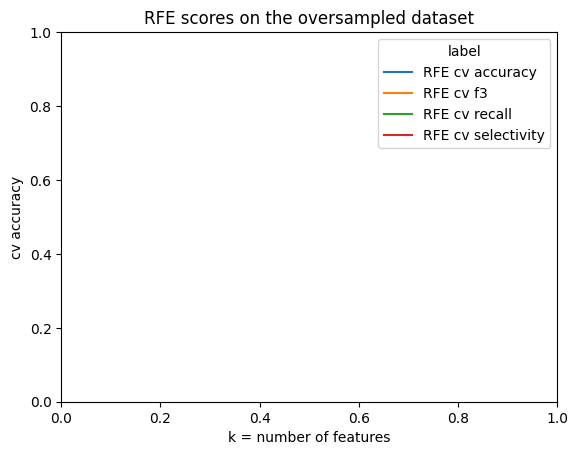

In [248]:
results_by_score = {}
for score in ["accuracy", "f3", "recall", "selectivity"]:
    results_by_score[score] = results_rfe_kfold_cv.copy()
    results_by_score[score]['label'] = "RFE cv " + score
    results_by_score[score]["score"] = results_rfe_kfold_cv[score]


results_all = pd.concat(results_by_score.values())

sns.lineplot(data = results_all, x = "k", y = "score", hue="label")
plt.ylabel("cv accuracy")
plt.xlabel("k = number of features")
plt.title("RFE scores on the oversampled dataset")
plt.show()

## 046 Choose best models 

Here we choose the best models selected with both the RFE algorithm.

In [249]:
k_rfe = 9
rfe_selected_features=results_rfe_kfold_cv.loc[k_rfe,"features"]

k_skb = 4
skb_selected_features=results_rfe_kfold_cv.loc[k_skb,"features"]

print(f"selected features for performance:",k_rfe, rfe_selected_features) 
print(f"\nselected features for simplicity:",k_skb, skb_selected_features) 

selected features for performance: 9 ['hemo', 'gender', 'time730', 'offtrt', 'time_censored', 'race', 'z30', 'cd420', 'drugs']

selected features for simplicity: 4 ['race', 'time_censored', 'time730', 'cd420', 'offtrt']


Now we fit the best models

In [250]:
model_rfe = OffLogistic(random_state=42) 
X_rfe_train = X_train[rfe_selected_features]
X_rfe_test = X_test[rfe_selected_features]
model_rfe.fit(X_rfe_train,y_train)

In [251]:
model_skb = OffLogistic(random_state=42) 
X_skb_train = X_train[skb_selected_features]
X_skb_test = X_test[skb_selected_features]
model_skb.fit(X_skb_train,y_train)

## 047 Discuss model performance

In [252]:
f3_score = make_scorer(fbeta_score, beta = 3)

In [253]:
from sklearn.model_selection import cross_validate 
def cv_mean_scores(Xtrain, ytrain, model = OffLogistic(random_state=42), n_splits  = 5):
    # Create the K-Fold cross-validator
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
     
    # Choose the scores to be computed
    selectivity_score = make_scorer(recall_score, pos_label = 0)
    negative_predictive_value = make_scorer(precision_score, pos_label = 0)


    my_scores= {
        "accuracy": "accuracy",
        "recall": "recall",   # true positive rate
        "selectivity": selectivity_score,   # true negative rate
        "precision": "precision",  # positive predictive value 
        "NPV": negative_predictive_value, # negative predictive value,
        "f1": "f1",
        "f3": f3_score,
        "ROC_AUC": "roc_auc"
    }

    # Perform cross-validation measuring the scores
    cv_results = cross_validate(
        model, Xtrain, ytrain, cv=cv, n_jobs=-1, scoring= my_scores
    )


    # Calculate the mean of each score
    mean_scores =  {score : cv_results["test_"+score].mean() for score in my_scores}
    return mean_scores

We evaluate the best SKB model

In [254]:
best_skb_cv_scores = cv_mean_scores(X_skb_train,y_train)
for score in best_skb_cv_scores:
    print(score, ":", f"{best_skb_cv_scores[score]:.3f}") 

accuracy : nan
recall : nan
selectivity : nan
precision : nan
NPV : nan
f1 : nan
f3 : nan
ROC_AUC : nan


In [257]:
best_rfe_cv_scores = cv_mean_scores(X_rfe_train,y_train)
for score in best_rfe_cv_scores:
    print(score, ":", f"{best_rfe_cv_scores[score]:.3f}") 

accuracy : nan
recall : nan
selectivity : nan
precision : nan
NPV : nan
f1 : nan
f3 : nan
ROC_AUC : nan


The model has no obvious weaknesses and it is very good on Recall (true positive rate), which is actually what we care about the most. 
In cross-validation, if a patient is truly "infected" then the model classifies the patient correctly 92% of the times, on cv_average. 

**Caveat** We are doing cross validation on a train set in which the target class "infected" has been oversampled. For this reason the score "Recall" may be too optimistic.

## 048 Interpret model coefficients 

In [256]:
# model intercept:

intercept_rfe = model_rfe.intercept_[0]
intercept_skb = model_skb.intercept_[0]


print(f"The intercept of the best SKB model is equal to {intercept_skb:.4f}")
print(f"The intercept of the best RFE model is equal to {intercept_rfe:.4f}")

AttributeError: 'OffLogistic' object has no attribute 'intercept_'

The intercept is negative. It means that an average patient is evaluated by the models with a bias. This bias is towards the "non-infected" class. 

In [186]:
# we calculate the model coefficients for each feature 

coefficients_skb = pd.DataFrame({
    "feature": skb_selected_features,
    "coefficient": model_skb.coef_[0]
})

coefficients_rfe = pd.DataFrame({
    "feature": rfe_selected_features,
    "coefficient": model_rfe.coef_[0]
})

coefficients_rfe.sort_values(by="coefficient", inplace=True)
coefficients_skb.sort_values(by="coefficient", inplace=True)


NameError: name 'model_skb' is not defined

NameError: name 'coefficients_skb' is not defined

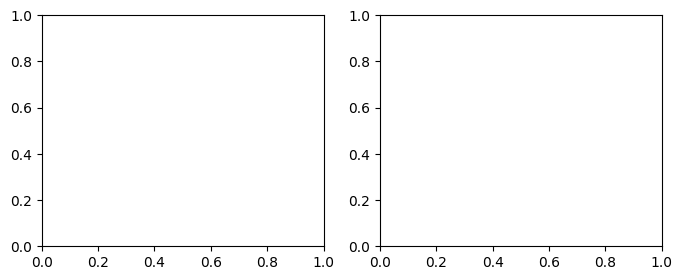

In [187]:
fig, axes = plt.subplots(1,2, figsize = (8,3))

sns.barplot(data = coefficients_skb, y = "feature", x = "coefficient", ax = axes[0])
sns.barplot(data = coefficients_rfe, y = "feature", x = "coefficient", ax = axes[1])

axes[0].set_title("Scaled coefficients for best SKB model")
axes[1].set_title("Scaled coefficients for best RFE model")

plt.tight_layout()
plt.show()

## 049 Render coefficients insights 

### 049-a Obtain coefficients for the unscaled variables

The coefficients found in 048 are relative to the features scaled with StandardScaler. They are therefore hard to interpret as they are. 
We now calculate the coefficients one gets for the un-scaled regressors. 

In [188]:
# for each variable we calculate the rate of scaling 
scaling_factors = pd.DataFrame({
    "feature": X_.columns,
    "scaling_factor": scaler.scale_
})
scaling_factors.head(3)

,feature,scaling_factor
0,age,8.676423
1,wtkg,13.182555
2,hemo,0.274985


In [189]:
# we merge with model coefficients 
coefficients_and_scaling_skb = coefficients_skb.merge(scaling_factors)
coefficients_and_scaling_rfe = coefficients_rfe.merge(scaling_factors)

# calculate un-scaled coefficient
coefficients_and_scaling_skb["coefficient_unscaled"] = coefficients_and_scaling_skb["coefficient"] / coefficients_and_scaling_skb["scaling_factor"]
coefficients_and_scaling_rfe["coefficient_unscaled"] = coefficients_and_scaling_rfe["coefficient"] / coefficients_and_scaling_rfe["scaling_factor"]

# order and print the results
coefficients_and_scaling_skb.sort_values(by="coefficient", ascending=False, inplace=True)
coefficients_and_scaling_rfe.sort_values(by="coefficient", ascending=False, inplace=True)

print("Feature coefficients of the model selected by SKB:")
print(coefficients_and_scaling_skb)
print()
print("Feature coefficients of the model selected by RFE:")
print(coefficients_and_scaling_skb)



NameError: name 'coefficients_skb' is not defined

### 049-b Model coefficients separately for binary vs continuous features

The log-odd contribution of our categorical variables is binary. The contribution of continuous features is proportional to their value. 
It is best to interpret the two types of variables separately. 

In [190]:
# we filter the categorical (binary) features 
binary_skb_mask = coefficients_and_scaling_skb['feature'].isin(cat_features)
binary_rfe_mask = coefficients_and_scaling_rfe['feature'].isin(cat_features)

coefficients_unscaled_skb_binary = coefficients_and_scaling_skb[binary_skb_mask].drop(columns = ["coefficient","scaling_factor"])
coefficients_unscaled_rfe_binary = coefficients_and_scaling_rfe[binary_rfe_mask].drop(columns = ["coefficient","scaling_factor"])

coefficients_unscaled_skb_continuous = coefficients_and_scaling_skb[~binary_skb_mask].drop(columns = ["coefficient","scaling_factor"])
coefficients_unscaled_rfe_continuous = coefficients_and_scaling_rfe[~binary_rfe_mask].drop(columns = ["coefficient","scaling_factor"])

# print for example
coefficients_unscaled_skb_binary


NameError: name 'coefficients_and_scaling_skb' is not defined

To better understand and compare the variables and coefficients we further custom-rescale the continuous variables.

In [191]:
# custom scale continuous features 

for coefficients_unscaled in [coefficients_unscaled_skb_continuous, coefficients_unscaled_rfe_continuous]:

    # - time730, time_censored : unit = month (scale 30)
    time_features_mask = coefficients_unscaled["feature"].isin(["time730","time_censored"])

    coefficients_unscaled.loc[time_features_mask, "feature"] += " (months)"
    coefficients_unscaled.loc[time_features_mask, "coefficient_unscaled"] *= 30

    # - cd40, cd420 : unit = hundreds (scale 100)
    lab_features_mask = coefficients_unscaled["feature"].isin(["cd40","cd420"])

    coefficients_unscaled.loc[lab_features_mask, "feature"] += " (x100)"
    coefficients_unscaled.loc[lab_features_mask, "coefficient_unscaled"] *= 100

print("Unscaled coefficients for SKB model")
print(coefficients_unscaled_skb_continuous)
print()
print("Unscaled coefficients for RFE model")
print(coefficients_unscaled_rfe_continuous)


NameError: name 'coefficients_unscaled_skb_continuous' is not defined

### 049-c Visualize coefficients of unscaled variables

NameError: name 'coefficients_unscaled_skb_binary' is not defined

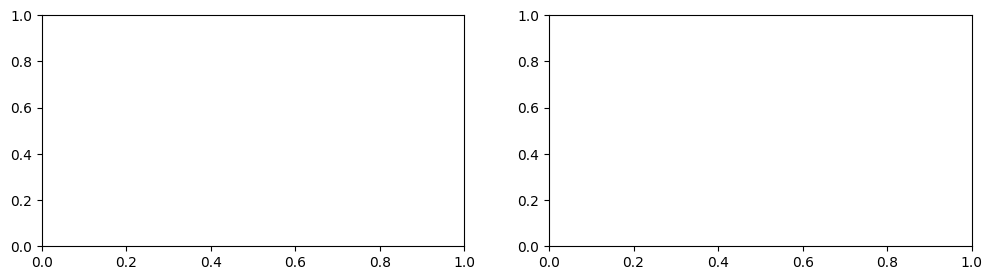

In [192]:
# Plot coefficients of binary features 
fig, axes = plt.subplots(1,2, figsize = (12,3))

sns.barplot(data = coefficients_unscaled_skb_binary, y = "feature", x = "coefficient_unscaled", ax = axes[0])
sns.barplot(data = coefficients_unscaled_rfe_binary, y = "feature", x = "coefficient_unscaled", ax = axes[1])

axes[0].set_title("Unscaled coefficients for best SKB model")
axes[1].set_title("Unscaled coefficients for best RFE model")

axes[0].set_ylabel("binary features")
axes[1].set_ylabel("binary features")
plt.tight_layout()
plt.show()

# Plot coefficients of continuous features
fig, axes = plt.subplots(1,2, figsize = (12,3))

sns.barplot(data = coefficients_unscaled_skb_continuous, y = "feature", x = "coefficient_unscaled", ax = axes[0])
sns.barplot(data = coefficients_unscaled_rfe_continuous, y = "feature", x = "coefficient_unscaled", ax = axes[1])

axes[0].set_title("Unscaled coefficients for best SKB model")
axes[1].set_title("Unscaled coefficients for best RFE model")

axes[0].set_ylabel("continuous features")
axes[1].set_ylabel("continous features")

plt.tight_layout()
plt.show()

## 050 + 052 Test set performance 

### Test performance with RFE

In [ ]:
y_pred_rfe = model_rfe.predict(X_rfe_test)

In [ ]:
results_test_rfe = {
    "accuracy": accuracy_score(y_test,y_pred_rfe),
    "recall": recall_score(y_test,y_pred_rfe),
    "selectivity": recall_score(y_test,y_pred_rfe,pos_label = 0),
    "precision": precision_score(y_test,y_pred_rfe),
    "NPV": precision_score(y_test,y_pred_rfe, pos_label = 0),
    "f1": f1_score(y_test,y_pred_rfe),
    "f3": fbeta_score(y_test,y_pred_rfe,beta = 3)
}

results_test_rfe

{'accuracy': 0.8948598130841121,
 'recall': np.float64(0.8076923076923077),
 'selectivity': np.float64(0.9228395061728395),
 'precision': np.float64(0.7706422018348624),
 'NPV': np.float64(0.9373040752351097),
 'f1': np.float64(0.7887323943661971),
 'f3': np.float64(0.8038277511961722)}

The recall score has dropped. The reason is clear: in cross-validation we used over-sampling. It would be better to oversample as part of the model. 

### Test performance with SKB

In [193]:
y_pred_skb = model_skb.predict(X_skb_test)

NameError: name 'model_skb' is not defined

In [194]:
results_test_skb = {
    "accuracy": accuracy_score(y_test,y_pred_skb),
    "recall": recall_score(y_test,y_pred_skb),
    "selectivity": recall_score(y_test,y_pred_skb,pos_label = 0),
    "precision": precision_score(y_test,y_pred_skb),
    "NPV": precision_score(y_test,y_pred_skb, pos_label = 0),
    "f1": f1_score(y_test,y_pred_skb),
    "f3": fbeta_score(y_test,y_pred_rfe,beta = 3)

}

results_test_skb

NameError: name 'y_pred_skb' is not defined

Interestingly, the recall is higher than the selectivity with this model. It would be interesting to know which features do help to increase the recall score.


In [195]:
print(rfe_selected_features)
print(skb_selected_features)

['hemo', 'gender', 'time730', 'offtrt', 'time_censored', 'race', 'z30', 'cd420', 'drugs']
['race', 'time_censored', 'time730', 'cd420', 'offtrt']


## 051 Confusion matrix 


In [196]:
cm_rfe  = confusion_matrix(y_test,y_pred_rfe)
cm_skb  = confusion_matrix(y_test,y_pred_skb)

NameError: name 'y_pred_rfe' is not defined

NameError: name 'cm_skb' is not defined

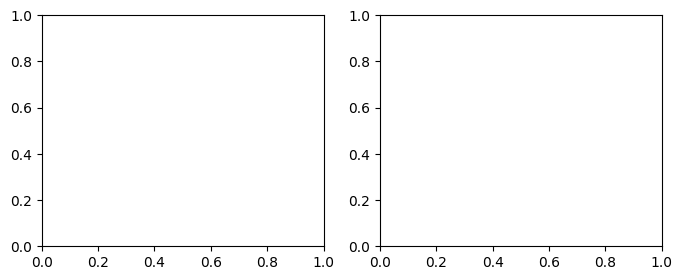

In [197]:
fig,ax = plt.subplots(1,2,figsize = (8,3))

sns.heatmap(cm_skb, annot=True, fmt='d', cmap='Blues', cbar=False, ax = ax[0])
sns.heatmap(cm_rfe, annot=True, fmt='d', cmap='Blues', cbar=False, ax = ax[1])

ax[0].set_title("Confusion matrix of SKB model")
ax[1].set_title("Confusion matrix of RFE model")
for i in [0,1]:
    ax[i].set_xlabel("Predicted Labels")
    ax[i].set_ylabel("True Labels")

plt.show()

In [ ]:
cm_rfe [0]

array([299,  25])

In [ ]:

num_test = [int(sum(cm_rfe[0])),int(sum(cm_rfe[1]))]
num_test

[324, 104]

## 053 Visualize confusion matrix data

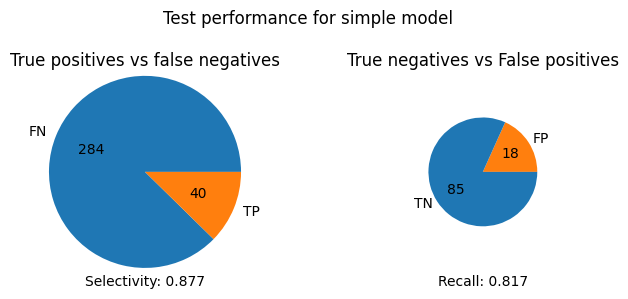

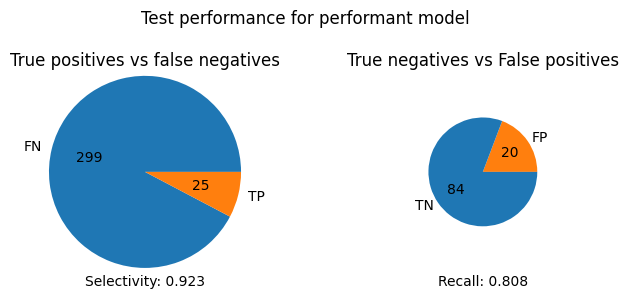

In [ ]:
fig,ax = plt.subplots(1,2,figsize = (7,3))

# true infected vs true not infected test data count
num_test = [int(sum(cm_skb[0])),int(sum(cm_skb[1]))]


ax[0].set_title("True positives vs false negatives")
ax[1].set_title("True negatives vs False positives")
labels_pie = [["FN", "TP"],["FP", "TN"]]

for i in [0,1]:
    ax[i].pie(cm_skb[i], 
        labels = labels_pie[i], 
        colors = [sns.color_palette()[i], sns.color_palette()[1-i]], 
        radius = np.sqrt(2*num_test[i] / (num_test[0] + num_test[1])),
        autopct= lambda p: f'{int(num_test[i] * p / 100 )}') # to compute the count instead of the percentage
    
ax[0].set_xlabel(f"Selectivity: {results_test_skb["selectivity"]:.3f}")
ax[1].set_xlabel(f"Recall: {results_test_skb["recall"]:.3f}")
fig.suptitle("Test performance for simple model")
plt.tight_layout()
plt.show()


fig,ax = plt.subplots(1,2,figsize = (7,3))

# true infected vs true not infected test data count
num_test = [int(sum(cm_rfe[0])),int(sum(cm_rfe[1]))]


ax[0].set_title("True positives vs false negatives")
ax[1].set_title("True negatives vs False positives")
labels_pie = [["FN", "TP"],["FP", "TN"]]

for i in [0,1]:
    ax[i].pie(cm_rfe[i], 
        labels = labels_pie[i], 
        colors = [sns.color_palette()[i], sns.color_palette()[1-i]], 
        radius = np.sqrt(2*num_test[i] / (num_test[0] + num_test[1])),
        autopct= lambda p: f'{int(num_test[i] * p / 100 )}') # to compute the count instead of the percentage
    
ax[0].set_xlabel(f"Selectivity: {results_test_rfe["selectivity"]:.3f}")
ax[1].set_xlabel(f"Recall: {results_test_rfe["recall"]:.3f}")
fig.suptitle("Test performance for performant model")


plt.tight_layout()
plt.show()



## Save Logistic Regression Model

In [198]:
import pickle

In [ ]:
# Save model to file
model = model_rfe
filename = "models/logistic_RFE9.pkl"
file = open(filename, "wb")
#pickle.dump(model, file)

# The wb indicates that the file is opened for writing in binary mode.




We also save to file the features

In [ ]:
#pickle.dump(results_rfe_kfold_cv['features'], open("models/rfe_features_250103.pkl", "wb"))